In [1]:
import dwave_sapi2
from dwave_sapi2.local import local_connection
from dwave_sapi2.remote import RemoteConnection
from dwave_sapi2.core import async_solve_ising, await_completion, solve_ising
from dwave_sapi2.util import get_hardware_adjacency, qubo_to_ising
from dwave_sapi2.embedding import find_embedding, embed_problem, unembed_answer
import time
import dwave_sapi2.remote
import sys
import matplotlib.pyplot as plt

import numpy as np
import scipy.io as sio
from scipy.stats import ortho_group
import math 
import random
from numpy import linalg as LA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import pandas as pd

In [2]:
conn = dwave_sapi2.remote.RemoteConnection('https://cloud.dwavesys.com/sapi','lanl-871046202c27322e8450da36b7b35653c94c1115')
print conn.solver_names()

['DW_2000Q_2_1', 'DW_2000Q_5', 'DW_2000Q_VFYC_2_1', 'c4-sw_optimize', 'DW_2000Q_VFYC_5', 'c4-sw_sample']


In [3]:
cd Desktop/LANL/AFRL-DISC Data/Blackbox brief for LANL

C:\Users\khenk\Desktop\LANL\AFRL-DISC Data\Blackbox brief for LANL


In [4]:
#load Desired data. Must be in vector form
sPCA= pd.read_csv('sPCA_32.csv', sep=',', encoding = 'utf8')
data = sPCA.values

In [5]:
#normalize data
for i in range(len(data)):
    data[i]=data[i]/LA.norm(data[i])

In [6]:
def sparse_loss(I,Phi,sparse_representation_coefficients,lam):
    Energy = .5*LA.norm(I-np.dot(Phi,sparse_representation_coefficients))**2 +lam*np.count_nonzero(sparse_representation_coefficients)
    return Energy

def reconstruction_loss(I,Phi,sparse_representation_coefficients):
    Loss = LA.norm(I-np.dot(Phi,sparse_representation_coefficients))**2
    return Loss

In [7]:
#Creating Randomly imprinted Phi Matrix with number of features = # Neurons/qubits
Neurons = 64
RandomTrainingSample_Index = random.sample(range(len(data)),Neurons)
Rand_Features = data[RandomTrainingSample_Index,:]


In [8]:
#Get ortho-orthogonal dictionary of size len of datato test lambda values
#m = ortho_group.rvs(dim=int(math.sqrt(len(data[1])))**2)
m = ortho_group.rvs(dim=32)
Phi = m
#Normalize
Phi.shape
# print(np.dot(Phi.T,Phi))
# print(LA.norm(np.dot(m.T,m)-np.dot(Phi.T,Phi)))

(32L, 32L)

In [9]:
Q = .5*np.dot(np.squeeze(Phi.T),np.squeeze(Phi))
#Q = np.asmatrix(np.squeeze(np.zeros((len(Phi.T),len(Phi.T)))))
lam = .25 #Undercomplete
lam_vector = np.full((len(Phi.T), 1), lam, dtype=np.float)
h_vector = np.add(-np.dot(Phi.T,Phi[:,0].T),np.squeeze(np.add(lam_vector,np.full((len(Phi.T), 1), lam, dtype=np.float))))
h_vector = np.squeeze(np.asarray(h_vector))
#Replace Diagonal of Q with corresponding h values    
for i in range(0,len(Q)):
    Q[i,i]=h_vector[i]

#Create Dictionary of Upper Triangle part of Q with Diagonal Elements
QDictionary ={}
for i in range(0,len(Q)):
    for j in range(i,len(Q)):
            QDictionary[(i,j)] = Q[i,j]
            #print(i,j,Q[i,j])

In [10]:
#Finding lowest Energy Embedding for faster run time (Could use some help analyzing complexity and run time differences) 
Embedding_Trials = 5
Unembedded_Solutions=[]
Embeddings =[]
EmbeddingTime=[]
J0 =[]
JC=[]
Coefficients_sol =[]
Coefficients_embsol=[]
solver = conn.get_solver('DW_2000Q_2_1') 
A = get_hardware_adjacency(solver)


for i in range(Embedding_Trials):
    
        (h_, J_, ising_offset) = qubo_to_ising(QDictionary)#Take QUBO problem to Ising
        print(np.asarray(h_).shape)
        #[h_,J_, offsetarg]= qubo_to_ising[Q]

        #solver = local_connection.get_solver("c4-sw_optimize") # dont select


        # find and print embeddings for problem graph
        t = time.time()

        embeddings = find_embedding(J_, A, verbose=1)
        elapsed = time.time() - t
        EmbeddingTime.append(elapsed)
        print "elapsed time:", elapsed
        #print "embeddings are: ", embeddings
        Embeddings.append(embeddings)

        # embed the problem into solver graph
        (h0, j0, jc, new_emb) = embed_problem(h_, J_, embeddings, A) #update to have multiple solutions and save embeddings
#         print "embedded problem result:\nj0: ", j0
#         print "jc: ", jc
        J0.append(j0)
        JC.append(jc)

        # find unembedded results for chain strengths -0.5, -1.0, -2.0

        Solutions =[]
        Answers=[]
        Chains = np.arange(- 3.5,-0.5,.5)
        for chain_strength in Chains:#Easier place to add more data to draw from than embeddings
                # set chain strength values
            jc = dict.fromkeys(jc, chain_strength)

            # create new J array concatenating j0 with jc
            emb_j = j0.copy()
            emb_j.update(jc)

                # solve embedded problem

            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
            Answers.append(answer['energies'])
            result = unembed_answer(answer['solutions'], new_emb, broken_chains="minimize_energy", h=h_, j=J_)
            Solutions.append(result)

        New_Solutions=[]
        #Convert to {0,1}
        for j in range(len(Chains)):
            x = np.asarray(Solutions[j][0])
            for i in range(0,len(x)):
                if x[i] == -1:
                     x[i] = 0
            New_Solutions.append(x)
            
        Unembedded_Solutions.append(New_Solutions)
        

(32L,)
component 0, try 0:
max overfill = 2, num max overfills = 18
max overfill = 1, num max overfills = 447
max overfill = 1, num max overfills = 394
max overfill = 1, num max overfills = 394
Embedding found. Minimizing chains...
max chain size = 16, num max chains = 2, qubits used = 394
max chain size = 16, num max chains = 2, qubits used = 394
max chain size = 15, num max chains = 5, qubits used = 409
max chain size = 14, num max chains = 8, qubits used = 384
max chain size = 14, num max chains = 3, qubits used = 377
max chain size = 14, num max chains = 3, qubits used = 377
elapsed time: 5.63399982452
(32L,)
component 0, try 0:
max overfill = 2, num max overfills = 20
max overfill = 1, num max overfills = 451
max overfill = 1, num max overfills = 459
max overfill = 1, num max overfills = 424
max overfill = 1, num max overfills = 424
Embedding found. Minimizing chains...
max chain size = 19, num max chains = 2, qubits used = 424
max chain size = 18, num max chains = 2, qubits used 

In [11]:
All_Energies = []
for i in range(len(Unembedded_Solutions)):
    Energy_Chain = []
    for j in range(len(Chains)):
        Energy_Chain.append(sparse_loss(Phi[:,0].T,Phi,np.asmatrix(Unembedded_Solutions[i][j]).T,lam))
    index_min = np.argmin(np.asarray(Energy_Chain))
    All_Energies.append(Energy_Chain[index_min])

In [12]:
index_min = np.argmin(np.asarray(All_Energies))
embeddings = Embeddings[index_min]

In [14]:
All_Sparse_Solutions = []


lam_values = np.arange(0,.75,.05)
lam_Reconstruction_Loss = []
for lam in lam_values:
    lam = lam #
    lam_vector = np.full((len(Phi.T), 1), lam, dtype=np.float)
    Total_Energies = []

    solver = conn.get_solver('DW_2000Q_2_1') 
    A = get_hardware_adjacency(solver)
    Unembedded_Solutions_Training= []
    Reconstruction_Error_Batch=[]
    t1 = time.time()
    New_Solutions = []
    Temp_Data_Patches=[]
    #Q = .5*np.dot(np.squeeze(Phi.T),np.squeeze(Phi))
    #Q = np.squeeze(np.zeros((len(Phi.T),len(Phi.T))))
    #print(Q.shape)


    J0 =[]
    JC=[]
    Coefficients_sol =[]
    Coefficients_embsol=[]
    image_number = 0
    
    number_of_images = len(Phi)
    for image in range( number_of_images):
        #print(LA.norm(Rand_Features[image]))
        temp = np.asarray(Phi[:,image])
        #print(LA.norm(temp))
        h_vector = np.add(-np.dot(Phi.T,temp),np.squeeze(np.add(lam_vector,np.full((len(Phi.T), 1), lam, dtype=np.float))))
        h_vector = np.squeeze(np.asarray(h_vector))
        #print(h_vector)
        #Replace Diagonal of Q with corresponding h values    
        for i in range(0,len(Q)):
            Q[i,i]=h_vector[i]
        #print(Q)
        #Create Dictionary of Upper Triangle part of Q with Diagonal Elements
        QDictionary ={}
        for i in range(0,len(Q)):
            for j in range(i,len(Q)):
                    QDictionary[(i,j)] = Q[i,j]
                    #print(i,j,Q[i,j])

        (h_, J_, ising_offset) = qubo_to_ising(QDictionary)
            #[h_,J_, offsetarg]= qubo_to_ising[Q]

        #embeddings = find_embedding(J_, A, verbose=1)
        (h0, j0, jc, new_emb) = embed_problem(h_, J_, embeddings, A)


        Temp_Data_Patches.append(temp)

            # solve embedded problem

        Solutions =[]
        Answers=[]
        Chains = np.arange(- 3.5,-0.5,.5)
        for chain_strength in Chains:
                # set chain strength values
            jc = dict.fromkeys(jc, chain_strength)

            # create new J array concatenating j0 with jc
            emb_j = j0.copy()
            emb_j.update(jc)

                # solve embedded problem
            try:
                answer = solve_ising(solver, h0, emb_j, num_reads=20)# save results in an array
                Answers.append(answer['energies'])
            except RuntimeError:
                time.sleep(30)
                print('Runtime Error: Resubmitting Problem to D-Wave')
                try:
                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                    Answers.append(answer['energies'])

                except RuntimeError:
                    time.sleep(30)
                    print('Runtime Error: Resubmitting Problem to D-Wave')
                    try:
                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                        Answers.append(answer['energies'])
                    except RuntimeError:
                        time.sleep(30)
                        print('Runtime Error: Resubmitting Problem to D-Wave')
                        try:
                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                            Answers.append(answer['energies'])

                        except RuntimeError:
                            time.sleep(30)
                            print('Runtime Error: Resubmitting Problem to D-Wave')
                            try:
                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                Answers.append(answer['energies'])

                            except RuntimeError:
                                time.sleep(30)
                                print('Runtime Error: Resubmitting Problem to D-Wave')
                                try:
                                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                    Answers.append(answer['energies'])

                                except RuntimeError:
                                    time.sleep(30)
                                    print('Runtime Error: Resubmitting Problem to D-Wave')
                                    try:
                                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                        Answers.append(answer['energies'])

                                    except RuntimeError:
                                        time.sleep(30)
                                        print('Runtime Error: Resubmitting Problem to D-Wave')
                                        try:
                                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                            Answers.append(answer['energies'])

                                        except RuntimeError:
                                            time.sleep(30)
                                            print('Runtime Error: Resubmitting Problem to D-Wave')
                                            try:
                                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                                Answers.append(answer['energies'])

                                            except RuntimeError:
                                                time.sleep(30)
                                                print('Runtime Error: Resubmitting Problem to D-Wave')
                                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                                Answers.append(answer['energies'])



                # unembed and print result of the form:
                # solution [solution #]
                # var [var #] : [var value] ([qubit index] : [original qubit value] ...)
            result = unembed_answer(answer['solutions'], new_emb, broken_chains="minimize_energy", h=h_, j=J_)
            Solutions.append(result)
            for i, (embsol, sol) in enumerate(zip(answer['solutions'], result)):
                for j, emb in enumerate(embeddings):
                    Coefficients_sol.append(sol[j])
                    for k in emb:
                        Coefficients_embsol.append(embsol[k])
        #print(Solutions)
        New_Solutions=[]
        #Convert to {0,1}
        for j in range(0,len(Chains)):
            x = np.asarray(Solutions[j][0])
            #print(x)
            x = (x+1)/2
            #print(x)
            New_Solutions.append(x)
        New_Solutions = np.asarray(New_Solutions)
        All_Energies =[]
        Reconstruction_Error_image = []
        for k in range(len(New_Solutions)): #Find for each chain strength
                #Energy function with 0 norm on lambda
                Energy = sparse_loss(temp,Phi,np.asmatrix(New_Solutions[k]).T,lam)
                Error = reconstruction_loss(temp,Phi,np.asmatrix(New_Solutions[k]).T)
                #print(Energy)
                All_Energies.append(Energy)
                Reconstruction_Error_image.append(Error)
        index_min = np.argmin(np.asarray(All_Energies))
        im = np.argmin(np.asarray(Reconstruction_Error_image))
        Reconstruction_Error_Batch.append(Reconstruction_Error_image[im])
        Unembedded_Solutions_Training.append(New_Solutions[index_min])
        #print(New_Solutions[index_min])
    print(lam)
    print(sum(np.asarray(Reconstruction_Error_Batch)))
    lam_Reconstruction_Loss.append(sum(np.asarray(Reconstruction_Error_Batch)))
    Sparse_Rep = np.asarray(Unembedded_Solutions_Training)
    Sparse_Rep = np.asmatrix(np.squeeze(np.asarray(Sparse_Rep)))
    All_Sparse_Solutions.append(Sparse_Rep)

0.0
13815.30979047442
0.05
9828.126362051556
0.1
8615.629393163686
0.15000000000000002
7936.073339172924
0.2
6350.752020217295
0.25
4956.148651019312
0.30000000000000004
4246.231951816157
0.35000000000000003
3559.427803522078
0.4
2460.593490107105
0.45
2260.099847972599
0.5
1745.9865847983067
0.55
1196.9980648249998
0.6000000000000001
1116.5461535442264
0.65
1055.1891260994794
0.7000000000000001
1055.9196475054284


In [15]:
All_Sparse_Solutions = np.asarray(All_Sparse_Solutions)
All_Reconstructions = []
for i in range(len(All_Sparse_Solutions)):
    All_Reconstructions.append(np.dot(All_Sparse_Solutions[i],Phi.T))
All_Reconstructions = np.asarray(All_Reconstructions)

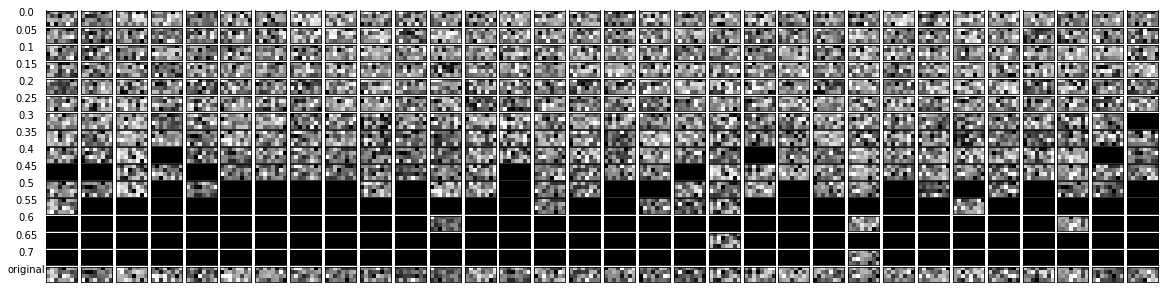

In [16]:
#Look for lambda value which acurately reconstructs the most orthogonal components

#recon_dim = int(math.sqrt(len(Phi)))
recon_dim1 = 4
recon_dim2 = 8
fig, ax = plt.subplots(len(All_Sparse_Solutions)+1, number_of_images, figsize=(20, 5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0))
for j in range(len(All_Sparse_Solutions)):
    for i in range(number_of_images):
        ax[j, i].imshow(All_Reconstructions[j][i].reshape(recon_dim1,recon_dim2),cmap='binary_r')
#         ax[1, i].imshow(Reconstructions[i].reshape(14,14), cmap='binary_r')
#         ax[2, i].imshow(Reconstructions_OptimalEmbedd[i].reshape(14,14), cmap='binary_r')
for k in range(number_of_images):
    ax[len(All_Sparse_Solutions), k].imshow(Phi[:,k].T.reshape(recon_dim1,recon_dim2),cmap='binary_r')    
    #print(projected[i].reshape(32,32).shape)
# ax[0, 0].set_ylabel('Down Sampled \nOriginal')    
# ax[1, 0].set_ylabel('DWave\n 32 sPCA\n Reconstruction\nw/Lambda = .5')
for i in range(len(lam_values)):
    ax[i,0].set_ylabel(str(round(lam_values[i], 2)),rotation=0,labelpad=20)
ax[len(All_Sparse_Solutions), 0].set_ylabel('original',rotation=0,labelpad=20);


In [16]:
lam_values


array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65])

In [157]:
lam_values

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65])

In [17]:
#Get Features for data phi and Normalize
Phi = Rand_Features.T
Phi = np.asmatrix(Phi)
for i in range(Neurons):
    Phi[:,i]= Phi[:,i]/(LA.norm(Phi[:,i]))

In [18]:
sio.savemat('Phi_Random_Lambda_.45_RSGD.mat', {'Phi':Phi})

In [19]:
#Pull Random images for SGD Training
Num_Ran_Sam =10000 
RandomTrainingSample_Index = random.sample(range(len(data)),Num_Ran_Sam)
Data_Patches = data[RandomTrainingSample_Index,:]

In [20]:
#Finding dictionary for 1 hamiltonian to find optimal embedding
Q = .5*np.dot(np.squeeze(Phi.T),np.squeeze(Phi))
lam = .45 #Set to best value from orthogonal work above
lam_vector = np.full((len(Phi.T), 1), lam, dtype=np.float)
h_vector = np.add(-np.dot(Phi.T,Data_Patches[0,:].T),np.squeeze(np.add(lam_vector,np.full((len(Phi.T), 1), lam, dtype=np.float))))
h_vector = np.squeeze(np.asarray(h_vector))
#Replace Diagonal of Q with corresponding h values    
for i in range(0,len(Q)):
    Q[i,i]=h_vector[i]

#Create Dictionary of Upper Triangle part of Q with Diagonal Elements
QDictionary ={}
for i in range(0,len(Q)):
    for j in range(i,len(Q)):
            QDictionary[(i,j)] = Q[i,j]
            #print(i,j,Q[i,j])

In [21]:
#Finding lowest Energy Embedding    
Embedding_Trials = 5
Unembedded_Solutions=[]
Embeddings =[]
EmbeddingTime=[]
J0 =[]
JC=[]
Coefficients_sol =[]
Coefficients_embsol=[]
solver = conn.get_solver('DW_2000Q_2_1') 
A = get_hardware_adjacency(solver)


for i in range(Embedding_Trials):
    
        (h_, J_, ising_offset) = qubo_to_ising(QDictionary)
        print(np.asarray(h_).shape)
        #[h_,J_, offsetarg]= qubo_to_ising[Q]

        #solver = local_connection.get_solver("c4-sw_optimize") # dont select


        # find and print embeddings for problem graph
        t = time.time()

        embeddings = find_embedding(J_, A, verbose=1)
        elapsed = time.time() - t
        EmbeddingTime.append(elapsed)
        print "elapsed time:", elapsed
        #print "embeddings are: ", embeddings
        Embeddings.append(embeddings)

        # embed the problem into solver graph
        (h0, j0, jc, new_emb) = embed_problem(h_, J_, embeddings, A) #update to have multiple solutions and save embeddings
#         print "embedded problem result:\nj0: ", j0
#         print "jc: ", jc
        J0.append(j0)
        JC.append(jc)

        # find unembedded results for chain strengths -0.5, -1.0, -2.0

        Solutions =[]
        Answers=[]
        Chains = np.arange(- 3.5,-0.5,.5)
        for chain_strength in Chains:
                # set chain strength values
            jc = dict.fromkeys(jc, chain_strength)

            # create new J array concatenating j0 with jc
            emb_j = j0.copy()
            emb_j.update(jc)

                # solve embedded problem

            answer = solve_ising(solver, h0, emb_j, num_reads=30)# save results in an array
            Answers.append(answer['energies'])
            result = unembed_answer(answer['solutions'], new_emb, broken_chains="minimize_energy", h=h_, j=J_)
            Solutions.append(result)

        New_Solutions=[]
        #Convert to {0,1} for each chain
        for j in range(len(Chains)):
            x = np.asarray(Solutions[j][0])
            for i in range(0,len(x)):
                if x[i] == -1:
                     x[i] = 0
            New_Solutions.append(x)
            
        Unembedded_Solutions.append(New_Solutions)
        
        
        if __name__ == "__main__":
            if len(sys.argv) == 1:
                embedding_example()
            else:
                print "Usage: "
                #print "%s: Find embedding for k_6 structured graph, embed problem, solve problem, unembed answer" % sys.argv[0]

(64L,)
component 0, try 0:
max overfill = 3, num max overfills = 2
max overfill = 2, num max overfills = 266
max overfill = 2, num max overfills = 243
max overfill = 2, num max overfills = 243
max overfill = 2, num max overfills = 240
max overfill = 2, num max overfills = 240
max overfill = 2, num max overfills = 176
max overfill = 2, num max overfills = 129
max overfill = 2, num max overfills = 111
max overfill = 2, num max overfills = 65
max overfill = 2, num max overfills = 65
max overfill = 2, num max overfills = 65
max overfill = 2, num max overfills = 65
max overfill = 2, num max overfills = 65
max overfill = 2, num max overfills = 64
max overfill = 2, num max overfills = 64
max overfill = 2, num max overfills = 63
max overfill = 2, num max overfills = 63
max overfill = 2, num max overfills = 63
max overfill = 2, num max overfills = 63
max overfill = 2, num max overfills = 63
max overfill = 2, num max overfills = 63
max overfill = 2, num max overfills = 63
max overfill = 2, num m

In [22]:
#Finding Energy of each solution from different embeddings and chain strengths. Take min for solution

All_Energies = []
for i in range(len(Unembedded_Solutions)):
    Energy_Chain = []
    for j in range(len(Chains)):
        Energy_Chain.append(sparse_loss(Data_Patches[0],Phi,np.asmatrix(Unembedded_Solutions[i][j]).T,lam))
    index_min = np.argmin(np.asarray(Energy_Chain))
    All_Energies.append(Energy_Chain[index_min])
index_min = np.argmin(np.asarray(All_Energies))
embeddings = Embeddings[index_min]

In [ ]:
#SGD Loop to update Dictionary

mini_batch_size = 1000
tol = 10**(-32)
max_iterations = 10000
eta =.005 #Learning Rate (Lower is better)
lam = .45 #found through orthogonal feature reconstructions above
lam_vector = np.full((len(Phi.T), 1), lam, dtype=np.float)
count = 0
Previous_Gradient = 0
momentum_term = .2



Total_Energies = []

solver = conn.get_solver('DW_2000Q_2_1') 
A = get_hardware_adjacency(solver)
Non_Zero_Coefficients =[12743] #Helps see how sparse reconstructions are while learning

for iteration in range(max_iterations):
    
        
    #Random Draw from Data
    Indexing = random.sample(range(len(Data_Patches)), mini_batch_size)
    
    Neuron_Activation =[]
    Gradients =[]
    Unembedded_Solutions_Training= []
    t1 = time.time()
    New_Solutions = []
    Temp_Data_Patches=[]
    Q = .5*np.dot(np.squeeze(Phi.T),np.squeeze(Phi))
    

    J0 =[]
    JC=[]
    Coefficients_sol =[]
    Coefficients_embsol=[]
    image_number = 0
    for sample in Indexing:
        
        h_vector = np.add(-np.dot(Phi.T,Data_Patches[sample,:].T),np.squeeze(np.add(lam_vector,np.full((len(Phi.T), 1), lam, dtype=np.float))))
        h_vector = np.squeeze(np.asarray(h_vector))
        #Replace Diagonal of Q with corresponding h values    
        for i in range(0,len(Q)):
            Q[i,i]=h_vector[i]

        #Create Dictionary of Upper Triangle part of Q with Diagonal Elements
        QDictionary ={}
        for i in range(0,len(Q)):
            for j in range(i,len(Q)):
                    QDictionary[(i,j)] = Q[i,j]
                    #print(i,j,Q[i,j])

        (h_, J_, ising_offset) = qubo_to_ising(QDictionary)
            #[h_,J_, offsetarg]= qubo_to_ising[Q]

#         embeddings = find_embedding(J_, A, verbose=1 #Fixed embedding massively speeds up process especially when fully connected
        (h0, j0, jc, new_emb) = embed_problem(h_, J_, embeddings, A) 

        Solutions =[]
        Answers=[]
        
        Temp_Data_Patches.append(Data_Patches[sample,:].T)

            # solve embedded problem
        
        Solutions =[]
        Answers=[]
        for chain_strength in Chains:
                # set chain strength values
            jc = dict.fromkeys(jc, chain_strength)

            # create new J array concatenating j0 with jc
            emb_j = j0.copy()
            emb_j.update(jc)

                # solve embedded problem with except statements incase QPU is having trouble connecting
            try:
                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                Answers.append(answer['energies'])
            except RuntimeError:
                time.sleep(30)
                print('Runtime Error: Resubmitting Problem to D-Wave')
                try:
                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                    Answers.append(answer['energies'])

                except RuntimeError:
                    time.sleep(30)
                    print('Runtime Error: Resubmitting Problem to D-Wave')
                    try:
                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                        Answers.append(answer['energies'])
                    except RuntimeError:
                        time.sleep(30)
                        print('Runtime Error: Resubmitting Problem to D-Wave')
                        try:
                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                            Answers.append(answer['energies'])

                        except RuntimeError:
                            time.sleep(30)
                            print('Runtime Error: Resubmitting Problem to D-Wave')
                            try:
                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                Answers.append(answer['energies'])

                            except RuntimeError:
                                time.sleep(30)
                                print('Runtime Error: Resubmitting Problem to D-Wave')
                                try:
                                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                    Answers.append(answer['energies'])

                                except RuntimeError:
                                    time.sleep(30)
                                    print('Runtime Error: Resubmitting Problem to D-Wave')
                                    try:
                                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                        Answers.append(answer['energies'])

                                    except RuntimeError:
                                        time.sleep(30)
                                        print('Runtime Error: Resubmitting Problem to D-Wave')
                                        try:
                                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                            Answers.append(answer['energies'])

                                        except RuntimeError:
                                            time.sleep(30)
                                            print('Runtime Error: Resubmitting Problem to D-Wave')
                                            try:
                                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                                Answers.append(answer['energies'])

                                            except RuntimeError:
                                                time.sleep(30)
                                                print('Runtime Error: Resubmitting Problem to D-Wave')
                                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                                Answers.append(answer['energies'])




            result = unembed_answer(answer['solutions'], new_emb, broken_chains="minimize_energy", h=h_, j=J_)
            Solutions.append(result)
            #Solutions.append(result['energies']) DOESNT HAVE energies AS AN OUTPUT

            #print(result)
            #print "result for chain strength = ", chain_strength
            for i, (embsol, sol) in enumerate(zip(answer['solutions'], result)):
                #print "solution", i
                #save solution coefficients
                for j, emb in enumerate(embeddings):
                    Coefficients_sol.append(sol[j])
                    #print "var %d: %d (" % (j, sol[j]),
                    for k in emb:
                        Coefficients_embsol.append(embsol[k])

        New_Solutions=[]
        #Convert to {0,1} in a faster way
        for j in range(0,len(Chains)):
            x = np.asarray(Solutions[j][0])
            x = (x+1)/2

            New_Solutions.append(x)
        New_Solutions = np.asarray(New_Solutions)
        All_Energies =[]
        for k in range(len(New_Solutions)): #Find for each chain strength
                #Energy function with 0 norm on lambda
                Energy = sparse_loss(Data_Patches[sample],Phi,np.asmatrix(New_Solutions[k]).T,lam)
                #print(Energy)
                All_Energies.append(Energy)
        index_min = np.argmin(np.asarray(All_Energies))
        Unembedded_Solutions_Training.append(New_Solutions[index_min])
        if image_number%10==0:
            print('Image Found', image_number)
        if image_number%100==0:
            print(New_Solutions[index_min])
        image_number+= 1

   


    Sparse_Rep = np.asarray(Unembedded_Solutions_Training)
    Sparse_Rep = np.asmatrix(np.squeeze(np.asarray(Sparse_Rep)))

    print('////////////////////////////////Sparse Reps Found\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\')
    Non_Zero_Coefficients.append(np.count_nonzero(Sparse_Rep))
    print('Non_Zero_Coefficient_Count',np.asarray(Non_Zero_Coefficients))
    #Unembedded_Solutions_Training = Sparse_Rep

    Temp_Data_Patches =np.asarray(Temp_Data_Patches)
    #Regular Hebbian SGD (no weighted average of neuron activity) Appears to converge and run faster. Less biologically accurate?
    Phi_New = Phi
    for i in range(mini_batch_size):
        error = np.subtract(Temp_Data_Patches[i].T,np.squeeze(np.dot(Phi,Unembedded_Solutions_Training[i].T)))
        Gradient = - (eta/mini_batch_size)*np.outer(error,Sparse_Rep[i]) + momentum_term*Previous_Gradient #Hebbian Learning
        Phi_New = Phi_New + Gradient
        Previous_Gradient = Gradient

    #normalize Updated Phi

    for i in range(Neurons):
    #print((math.sqrt(Phi[:,i].T*Phi[:,i])))
        Phi_New[:,i]= Phi_New[:,i]/(math.sqrt(np.dot(Phi_New[:,i].T,Phi_New[:,i])))
    #print((math.sqrt(Phi[:,i].T*Phi[:,i])))
    if iteration ==0:
        Energies =[]
        for i in range(mini_batch_size):
            Energies.append(sparse_loss(Temp_Data_Patches[i],Phi,Sparse_Rep[i].T,lam))
        Energy = np.sum(np.asarray(Energies))/mini_batch_size
        Total_Energies.append(Energy)
    
    Energies =[]
    for i in range(mini_batch_size):
        Energies.append(sparse_loss(Temp_Data_Patches[i],Phi_New,Sparse_Rep[i].T,lam))
    Energy = np.sum(np.asarray(Energies))/mini_batch_size

    Total_Energies.append(Energy)

    count += 1

    #print(plt.plot(range(iteration+1), Total_Energies ))
    print('Energies,Epoc :', Total_Energies,count)
    elapsed1 = time.time() - t1
    print(elapsed1)


    sio.savemat('Phi_New_Fashion_MiniBatch1000_sPCA_AFRL_32_Lambda_.55_RSGD.mat', {'Phi_New':Phi_New})
    sio.savemat('TotalEnergies_Fashion_MiniBatch1000_sPCA_AFRL_32_Lambda_.55_RSGD.mat', {'Total_Energies':Total_Energies})
    if LA.norm(Phi_New-Phi) > tol:
        print(LA.norm(Phi_New-Phi))
        Phi = Phi_New


    else:
        print('converged')
        
        break

        
        





('Image Found', 0)
[0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
('Image Found', 10)
('Image Found', 20)
('Image Found', 30)
('Image Found', 40)
('Image Found', 50)
('Image Found', 60)
('Image Found', 70)
('Image Found', 80)
('Image Found', 90)
('Image Found', 100)
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('Image Found', 110)
('Image Found', 120)
('Image Found', 130)
('Image Found', 140)
('Image Found', 150)
('Image Found', 160)
('Image Found', 170)
('Image Found', 180)
('Image Found', 190)
('Image Found', 200)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1]
('Image Found', 210)
('Image Found', 220)
('Image Found', 230)
('Image Found', 240)
('Image Found', 250)
('Image Found', 260)
('Image Found', 270)
('Image Found', 280)
('Image F

('Image Found', 260)
('Image Found', 270)
('Image Found', 280)
('Image Found', 290)
('Image Found', 300)
[0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
('Image Found', 310)
('Image Found', 320)
('Image Found', 330)
('Image Found', 340)
('Image Found', 350)
('Image Found', 360)
('Image Found', 370)
('Image Found', 380)
('Image Found', 390)
('Image Found', 400)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
('Image Found', 410)
('Image Found', 420)
('Image Found', 430)
('Image Found', 440)
('Image Found', 450)
('Image Found', 460)
('Image Found', 470)
('Image Found', 480)
('Image Found', 490)
('Image Found', 500)
[1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1]
('Image Found', 510)
('Image Found', 520)
('Image Found', 530)
('Image Found', 540

In [25]:
Total_Energies

[]

In [ ]:
#Get some reconstructions from trained Dicitionary 

Unembedded_Solutions_Training= []
t1 = time.time()
New_Solutions = []
Temp_Data_Patches=[]
Q = .5*np.dot(np.squeeze(Phi.T),np.squeeze(Phi))


J0 =[]
JC=[]
Coefficients_sol =[]
Coefficients_embsol=[]
image_number = 0

#lam = .1
lam_vector = np.full((len(Phi.T), 1), lam, dtype=np.float)
count = 0


solver = conn.get_solver('DW_2000Q_2_1') 
A = get_hardware_adjacency(solver)

#Can be used to get entire sparse rep of desired data set. 
#Only looking at 10 to get idea of learning
for image in range(10):

    h_vector = np.add(-np.dot(Phi.T,data[image].T),np.squeeze(np.add(lam_vector,np.full((len(Phi.T), 1), lam, dtype=np.float))))
    h_vector = np.squeeze(np.asarray(h_vector))
    #Replace Diagonal of Q with corresponding h values    
    for i in range(0,len(Q)):
        Q[i,i]=h_vector[i]

    #Create Dictionary of Upper Triangle part of Q with Diagonal Elements
    QDictionary ={}
    for i in range(0,len(Q)):
        for j in range(i,len(Q)):
                QDictionary[(i,j)] = Q[i,j]
                #print(i,j,Q[i,j])

    (h_, J_, ising_offset) = qubo_to_ising(QDictionary)
        #[h_,J_, offsetarg]= qubo_to_ising[Q]

#         embeddings = find_embedding(J_, A, verbose=1)
    (h0, j0, jc, new_emb) = embed_problem(h_, J_, embeddings, A)

    Solutions =[]
    Answers=[]

    Temp_Data_Patches.append(data[image].T)

        # solve embedded problem

    Solutions =[]
    Answers=[]
    for chain_strength in Chains:
            # set chain strength values
        jc = dict.fromkeys(jc, chain_strength)

        # create new J array concatenating j0 with jc
        emb_j = j0.copy()
        emb_j.update(jc)

            # solve embedded problem
        try:
            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
            Answers.append(answer['energies'])
        except RuntimeError:
            time.sleep(30)
            print('Runtime Error: Resubmitting Problem to D-Wave')
            try:
                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                Answers.append(answer['energies'])

            except RuntimeError:
                time.sleep(30)
                print('Runtime Error: Resubmitting Problem to D-Wave')
                try:
                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                    Answers.append(answer['energies'])
                except RuntimeError:
                    time.sleep(30)
                    print('Runtime Error: Resubmitting Problem to D-Wave')
                    try:
                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                        Answers.append(answer['energies'])

                    except RuntimeError:
                        time.sleep(30)
                        print('Runtime Error: Resubmitting Problem to D-Wave')
                        try:
                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                            Answers.append(answer['energies'])

                        except RuntimeError:
                            time.sleep(30)
                            print('Runtime Error: Resubmitting Problem to D-Wave')
                            try:
                                answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                Answers.append(answer['energies'])

                            except RuntimeError:
                                time.sleep(30)
                                print('Runtime Error: Resubmitting Problem to D-Wave')
                                try:
                                    answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                    Answers.append(answer['energies'])

                                except RuntimeError:
                                    time.sleep(30)
                                    print('Runtime Error: Resubmitting Problem to D-Wave')
                                    try:
                                        answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                        Answers.append(answer['energies'])

                                    except RuntimeError:
                                        time.sleep(30)
                                        print('Runtime Error: Resubmitting Problem to D-Wave')
                                        try:
                                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                            Answers.append(answer['energies'])

                                        except RuntimeError:
                                            time.sleep(30)
                                            print('Runtime Error: Resubmitting Problem to D-Wave')
                                            answer = solve_ising(solver, h0, emb_j, num_reads=10)# save results in an array
                                            Answers.append(answer['energies'])



            # unembed and print result of the form:
            # solution [solution #]
            # var [var #] : [var value] ([qubit index] : [original qubit value] ...)
        result = unembed_answer(answer['solutions'], new_emb, broken_chains="minimize_energy", h=h_, j=J_)
        Solutions.append(result)
        #Solutions.append(result['energies']) DOESNT HAVE energies AS AN OUTPUT

        #print(result)
        #print "result for chain strength = ", chain_strength
        for i, (embsol, sol) in enumerate(zip(answer['solutions'], result)):
            #print "solution", i
            #save solution coefficients
            for j, emb in enumerate(embeddings):
                Coefficients_sol.append(sol[j])
                #print "var %d: %d (" % (j, sol[j]),
                for k in emb:
                    Coefficients_embsol.append(embsol[k])
                    #print "%d:%d" % (k, embsol[k]),
                #print ")"
        #print "Solutions", Solutions
    New_Solutions=[]
    #Convert to {0,1}
    for j in range(Chains):
        x = np.asarray(Solutions[j][0])
        x = (x+1)/2
#             for i in range(0,Phi.shape[1]):
#                 if x[i] == -1:
#                      x[i] = 0
        New_Solutions.append(x)
    New_Solutions = np.asarray(New_Solutions)
    All_Energies =[]
    for k in range(len(New_Solutions)): #Find for each chain strength
            #Energy function with 0 norm on lambda
            Energy = sparse_loss(data[image],Phi,np.asmatrix(New_Solutions[k]).T,lam)
            #print(Energy)
            All_Energies.append(Energy)
    index_min = np.argmin(np.asarray(All_Energies))
    Unembedded_Solutions_Training.append(New_Solutions[index_min])
    if image_number%100==0:
        print('Image Found', image_number)
    if image_number%100==0:
        print(New_Solutions[index_min])
    image_number+= 1




Sparse_Rep = np.asarray(Unembedded_Solutions_Training)
Sparse_Rep = np.asmatrix(np.squeeze(np.asarray(Sparse_Rep)))

In [ ]:
#Niave Build of Reconstructions
All_Reconstructions_Trained = []
for i in range(len(Sparse_Rep)):
    All_Reconstructions_Trained.append(np.dot(Sparse_Rep[i],Phi.T))
All_Reconstructions_Trained = np.asarray(All_Reconstructions_Trained)

In [ ]:
#Load original Phi
mat = sio.loadmat('Phi_Random_Lambda_.55_RSGD.mat')
Untrained_Phi = mat['Phi']

In [ ]:
#Vectorized Build
All_Rec_Trained = np.dot(Sparse_Rep,Phi.T)
All_Rec_Untrained = np.dot(Sparse_Rep,Untrained_Phi.T)

In [18]:
#Load sPCA Dictionary from foundsPCA components
mat = sio.loadmat('sPCA_Phi.mat')
sPCA_Phi = mat['sPCA_Phi']

(64L, 1L)

In [ ]:
Gradient = - (eta/mini_batch_size)*np.dot(Phi,error) + momentum_term*Previous_Gradient

In [ ]:
All_Rec_sPCA = np.dot()

In [ ]:
All_Reconstructions_UnTrained = []
for i in range(len(Sparse_Rep)):
    All_Reconstructions_UnTrained.append(np.dot(Sparse_Rep[i],sPCA_Phi.T))
All_Reconstructions_UnTrained = np.asarray(All_Reconstructions_Trained)

In [20]:
np.outer(error,Sparse_Rep[i]).shape

(32L, 64L)

In [19]:
Phi_New.shape

(32L, 64L)